## Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import isuelogit as isl
import seaborn as sns

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

main dir: /Users/pablo/github/gisuelogit


In [3]:
# Internal modules
from src.gisuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates
from src.gisuelogit.models import UtilityParameters, BPRParameters
from src.gisuelogit.networks import build_tntp_network

## Build network

In [4]:
network_name = 'SiouxFalls'
tntp_network = build_tntp_network(network_name=network_name)

## Read OD matrix

In [5]:
Q = isl.reader.read_tntp_od(network_name=network_name)
tntp_network.load_OD(Q=Q)

Reading Q from external file
Matrix Q (24, 24) read in 0.5[s]                        

360600.0 trips were loaded among 528 o-d pairs


## Read data

In [6]:
# Synthethic data which was generated under the assumption of path sets of size 2.
df = pd.read_csv(
    main_dir + '/output/network-data/' + tntp_network.key + '/links/' + tntp_network.key + '-link-data.csv')

## Parameters

In [7]:
features_Z = ['tt_sd', 's']

n_sparse_features = 0
features_sparse = ['k' + str(i) for i in np.arange(0, n_sparse_features)]
features_Z.extend(features_sparse)

utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(tntp_network.links)},
                                       true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                       trainables={'psc_factor': False, 'fixed_effect': False
                                           , 'tt': True, 'tt_sd': True, 's': True},
                                       )

bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                               true_values={'alpha': 0.15, 'beta': 4},
                               trainables=dict.fromkeys(['alpha', 'beta'], True),
                               # trainables={'alpha': False, 'beta': True}
                               )

## Configuration

In [27]:
_XTICKS_SPACING = 500

## Read models results

In [9]:
ts = 230211181251
train_results_dfs = pd.read_csv(f'output/tables/{ts}_train_results_SiouxFalls.csv', index_col = [0])
test_results_dfs = pd.read_csv(f'output/tables/{ts}_validation_results_SiouxFalls.csv', index_col = [0])

### Model 1: Equilibrium

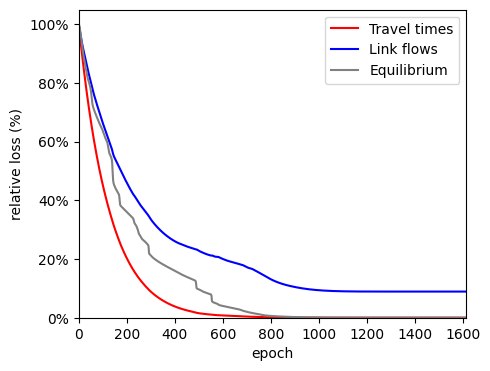

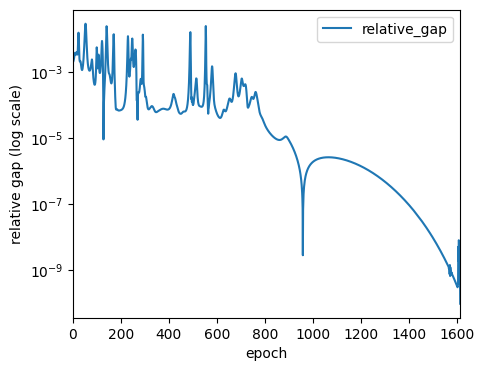

alpha =  0.15, beta  =  4.00


In [10]:
plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'suelogit'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'suelogit'],
                            show_validation= False, xticks_spacing= _XTICKS_SPACING)

fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs[train_results_dfs.model == 'suelogit'].\
        assign(relative_gap = np.abs(train_results_dfs[train_results_dfs.model == 'suelogit']['relative_gap']))[['epoch','relative_gap']],
    xticks_spacing= _XTICKS_SPACING)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.set_xlim(xmin=0)
plt.show()

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}, "
#       f"rr = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'suelogit']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'suelogit']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")

### Model 2: Benchmark of gisuelogit and isuelogit


LUE: Benchmark of gisuelogit and isuelogit (utility only)
alpha =  0.15, beta  =  4.00


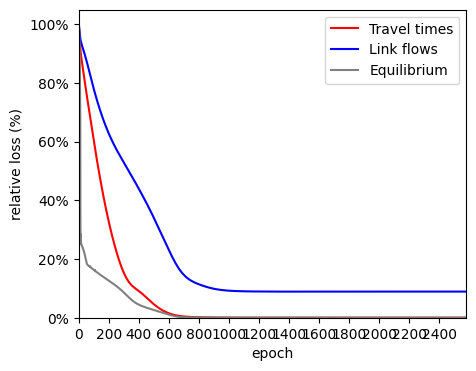

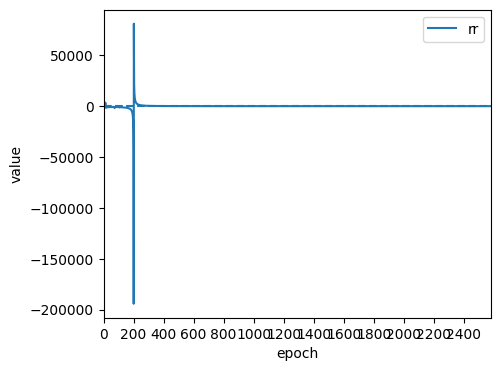

In [11]:

print('\nLUE: Benchmark of gisuelogit and isuelogit (utility only)')


plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'lue'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'lue'],
                            show_validation= False, xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'lue'].\
                           assign(rr = train_results_dfs[train_results_dfs.model == 'lue'].eval('tt_sd/tt'))[['epoch','rr']],
                           true_values={'rr':utility_parameters.true_values['tt_sd']/utility_parameters.true_values['tt']},
                            xticks_spacing=_XTICKS_SPACING)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}, "
#       f"rr = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'lue']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'lue']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")

### Model 3: estimation of link performance parameters (LPE)


LPE: link performance estimation
alpha =  0.15, beta  =  4.03


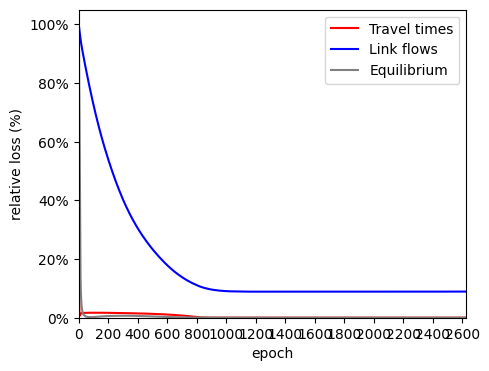

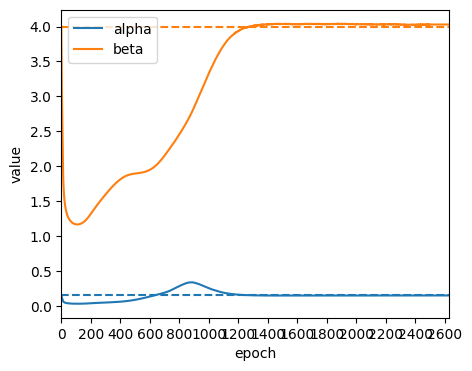

In [12]:

print('\nLPE: link performance estimation')

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'lpe'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'lpe'],
                            show_validation= False, xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'lpe'][['epoch','alpha','beta']],
                           true_values=bpr_parameters.true_values, xticks_spacing = _XTICKS_SPACING)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}, "
#       f"rr = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'lpe']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'lpe']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")

## Model 3: ODE with historic OD


 ODE: OD estimation with historic OD
alpha =  0.15, beta  =  4.00


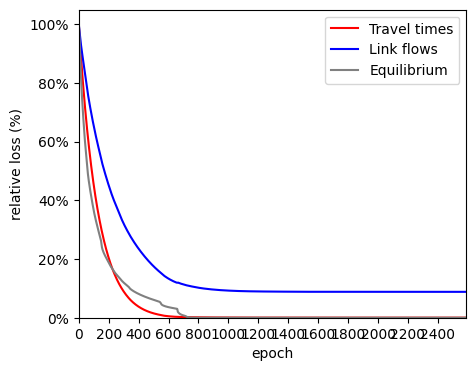

In [13]:
print('\n ODE: OD estimation with historic OD')

# Q_historic = isl.factory.random_disturbance_Q(tntp_network.Q, sd=np.mean(tntp_network.Q) * 0.1).copy()

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'ode'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'ode'],
                            show_validation= False, xticks_spacing = _XTICKS_SPACING)

# TODO: Store estimated and historic OD matrix during training
#Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(ode.Q).numpy()}
# plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}, "
#       f"rr = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'ode']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'ode']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")

### Model 4: OD + utility estimation


ODLUE: OD + utility estimation 
alpha =  0.15, beta  =  4.00


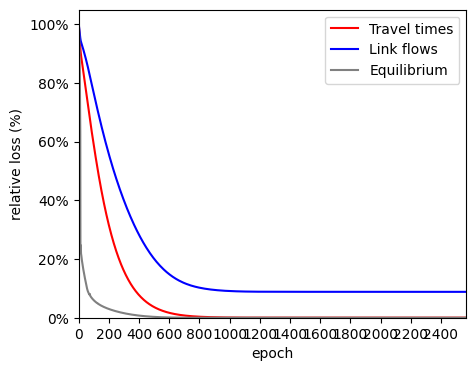

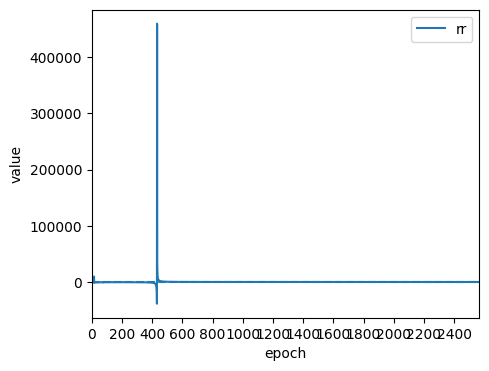

In [14]:

print('\nODLUE: OD + utility estimation ')

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlue'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlue'],
                            show_validation= False, xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'odlue'].\
                                                      assign(rr = train_results_dfs[train_results_dfs.model == 'odlue'].eval('tt_sd/tt'))[['epoch','rr']],
                           true_values={'rr':utility_parameters.true_values['tt_sd']/utility_parameters.true_values['tt']},
                            xticks_spacing = _XTICKS_SPACING)


# TODO: Store estimated and historic OD matrix during training
# Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlue.Q).numpy()}
# plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))


# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}, "
#       f"rr = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlue']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlue']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")

## Model 5: ODLUE + link specific performance parameters


ODLULPE: ODLUE + link performance parameters with historic OD matrix
alpha =  0.09, beta  =  4.10


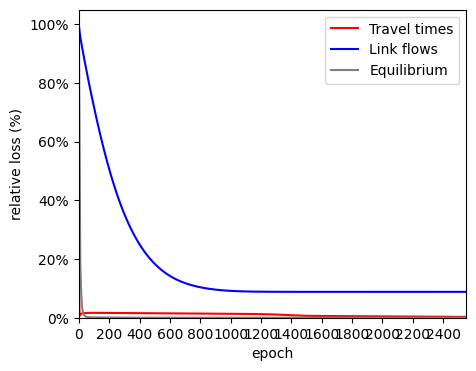

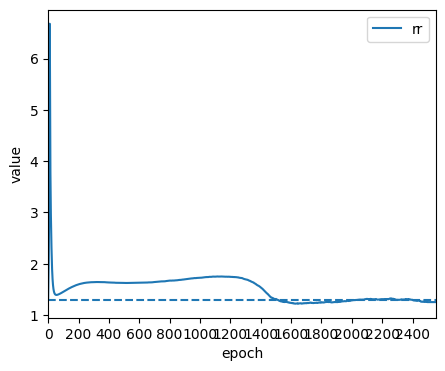

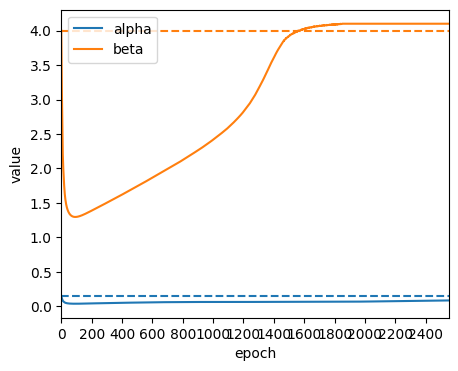

In [15]:

print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix')


plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlulpe'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlulpe'],
                            show_validation= False, xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'odlulpe'].\
                           assign(rr = train_results_dfs[train_results_dfs.model == 'odlulpe'].eval('tt_sd/tt'))[['epoch','rr']],
                           true_values={'rr':utility_parameters.true_values['tt_sd']/utility_parameters.true_values['tt']},
                            xticks_spacing=_XTICKS_SPACING)

plot_convergence_estimates(
    estimates=train_results_dfs[train_results_dfs.model == 'odlulpe'][['epoch','alpha','beta']],
    true_values=bpr_parameters.true_values,
    xticks_spacing = _XTICKS_SPACING)

# TODO: Store estimated and historic OD matrix during training
# Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlulpe.Q).numpy()}
#
# plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))
#
# plt.show()
#
# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}, "
#       f"rr = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlulpe']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlulpe']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")

## Plot of convergence toward true rr across models

In [34]:
models = ['lue','odlue','odlulpe']

train_estimates = {}
train_losses = {}

for model in models:
    train_estimates[model] = train_results_dfs[train_results_dfs.model == model]
    # train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd']/train_estimates_df['tt']

estimates = train_estimates_df[['epoch','model','rr']].reset_index().drop('index',axis = 1)
estimates = estimates[estimates.epoch >=500]
#estimates = estimates[estimates.epoch != 0]

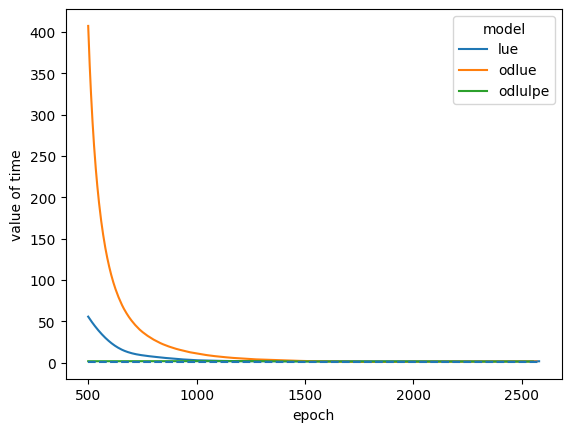

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.hlines(y=utility_parameters.true_values['tt_sd']/utility_parameters.true_values['tt'], xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('value of time')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, _XTICKS_SPACING))
#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()